한국에서는 MBTI가 유행
그리고 이를 통한 상황극이나 밈이 인기를 끌고, 
유명인들의 MBTI 성격 유형을 찾아보고 이에 비슷한 성격 유형 테스트들이 대중화되었음

빅데이터를 통해 개인화된 광고와 컨텐츠를 보여주는 시대
이를 사용해 소비자의 심리를 분석하고 원하는 상품을 기획 및 제작하는 것이 도움이 될 것이라 판단

colab이나 파이참으로 해볼 것~!~!~!~
XGBoost랑 CatBoost

# 1. import & Data check

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import os 
import re

import warnings
warnings.filterwarnings('ignore')

In [2]:
os.listdir('./dataset/')

['bike-sharing-demand',
 'house-prices-advanced-regression-techniques',
 'mbti_1.csv']

In [57]:
df = pd.read_csv('./dataset/mbti_1.csv')
df.head()

type                                              posts
0  INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1  ENTP  'I'm finding the lack of me in these posts ver...
2  INTP  'Good one  _____   https://www.youtube.com/wat...
3  INTJ  'Dear INTP,   I enjoyed our conversation the o...
4  ENTJ  'You're fired.|||That's another silly misconce...

## 1) 데이터 확인

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8675 non-null   object
 1   posts   8675 non-null   object
dtypes: object(2)
memory usage: 135.7+ KB


In [4]:
df.shape
# 8675개의 데이터

(8675, 2)

In [5]:
df['type'].value_counts()
# type별 몇개씩 존재하는지 확인

INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: type, dtype: int64

## 2) posts 분리  

'|||' 으로 구분되어 있는 것은 split 하고 comment마다 words와 words의 개수를 분산으로

In [58]:
# variance func
def var_row(row):
    l = []
    for i in row.split('|||'):
        l.append(len(i.split()))
    return np.var(l)

# words per comment
df['word_per'] = df['posts'].apply(lambda x : len(x.split())/50) # 평균 문자 갯수, 50은 총 comment 수 
df['variance_of_word_counts'] = df['posts'].apply(lambda x : var_row(x)) # 분산 
df.head()

type                                              posts  word_per  \
0  INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...     11.12   
1  ENTP  'I'm finding the lack of me in these posts ver...     23.40   
2  INTP  'Good one  _____   https://www.youtube.com/wat...     16.72   
3  INTJ  'Dear INTP,   I enjoyed our conversation the o...     21.28   
4  ENTJ  'You're fired.|||That's another silly misconce...     19.34   

   variance_of_word_counts  
0                 135.2900  
1                 187.4756  
2                 180.6900  
3                 181.8324  
4                 196.4576

근데, 여기서 얻을 단어들을 그냥 추출하는 것보다  
정규표현식 re를 사용해서 다시해 볼거야

In [73]:
def words(text):
    regex = re.compile('[%s]' % re.escape('|'))
    text = regex.sub(" ", text)
    text = regex.sub(" ", text)
    words = str(text).split()
    words = [i for i in words]
    return words

# def var_row(row):
#     l = []
#     for i in row.split('|||'):
#         l.append(len(i.split()))
#     return np.var(l)

def var_row(text):
    regex = re.compile('[%s]' % re.escape('|'))
    text = regex.sub(" ", text)
    text = regex.sub(" ", text)
    
    l= []
    for i in str(text):
        l.append(len(i.split()))
    return np.var(l)
#     l = []
#     for i in words:
#         l.append(len(words))
#     return np.var(l)

df['words'] = df['posts'].apply(words)
df['words_per'] = df['posts'].apply(lambda x : len(words(x))/50)
df['var_per'] = df['posts'].apply(lambda x : var_row(x))
df.head()

type                                              posts  word_per  \
0  INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...     11.12   
1  ENTP  'I'm finding the lack of me in these posts ver...     23.40   
2  INTP  'Good one  _____   https://www.youtube.com/wat...     16.72   
3  INTJ  'Dear INTP,   I enjoyed our conversation the o...     21.28   
4  ENTJ  'You're fired.|||That's another silly misconce...     19.34   

   variance_of_word_counts                                              words  \
0                 135.2900  ['http://www.youtube.com/watch?v=qsXHcwe3krw, ...   
1                 187.4756  ['I'm, finding, the, lack, of, me, in, these, ...   
2                 180.6900  ['Good, one, _____, https://www.youtube.com/wa...   
3                 181.8324  ['Dear, INTP,, I, enjoyed, our, conversation, ...   
4                 196.4576  ['You're, fired., That's, another, silly, misc...   

   words_per   var_per  
0      12.10  0.131411  
1      24.38  0.153894  
2      17.70  0.155617  
3      22.26  0.159310  
4      20.32  0.151029

In [8]:
# 처음에 만든 word 열 삭제

df.drop('word_per', axis = 1, inplace=True)
df.head()

type                                              posts  \
0  INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...   
1  ENTP  'I'm finding the lack of me in these posts ver...   
2  INTP  'Good one  _____   https://www.youtube.com/wat...   
3  INTJ  'Dear INTP,   I enjoyed our conversation the o...   
4  ENTJ  'You're fired.|||That's another silly misconce...   

                                               words  words_per  
0  ['http://www.youtube.com/watch?v=qsXHcwe3krw, ...      12.10  
1  ['I'm, finding, the, lack, of, me, in, these, ...      24.38  
2  ['Good, one, _____, https://www.youtube.com/wa...      17.70  
3  ['Dear, INTP,, I, enjoyed, our, conversation, ...      22.26  
4  ['You're, fired., That's, another, silly, misc...      20.32

In [9]:
# hyper text는 단어 아니야 - 링크 추출
def hyper_text(text):
    words = [i for i in text if "http" in i]
    return words

# another code
# df['hyper_link'] = df['posts'].apply(lambda x : x.count("http"))

# none hyper text - 링크 아닌것들 추출
def none_hyper_text(text):
    words = [i for i in text if not "http" in i]
    return len(words)

df['hyper_text'] = df['words'].apply(hyper_text)
df['hyper_per'] = df['words'].apply(lambda x : len(hyper_text(x))/50)
df['none_hyper_per'] = df['words'].apply(lambda x : none_hyper_text(x)/50)
df.head()

type                                              posts  \
0  INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...   
1  ENTP  'I'm finding the lack of me in these posts ver...   
2  INTP  'Good one  _____   https://www.youtube.com/wat...   
3  INTJ  'Dear INTP,   I enjoyed our conversation the o...   
4  ENTJ  'You're fired.|||That's another silly misconce...   

                                               words  words_per  \
0  ['http://www.youtube.com/watch?v=qsXHcwe3krw, ...      12.10   
1  ['I'm, finding, the, lack, of, me, in, these, ...      24.38   
2  ['Good, one, _____, https://www.youtube.com/wa...      17.70   
3  ['Dear, INTP,, I, enjoyed, our, conversation, ...      22.26   
4  ['You're, fired., That's, another, silly, misc...      20.32   

                                          hyper_text  hyper_per  \
0  ['http://www.youtube.com/watch?v=qsXHcwe3krw, ...       0.48   
1  [http://img188.imageshack.us/img188/6422/6020d...       0.18   
2  [https://www.youtube.com/watch?v=fHiGbolFFGw, ...       0.10   
3  [https://www.youtube.com/watch?v=uelHwf8o7_U, ...       0.04   
4  [https://www.youtube.com/watch?v=Xh0vA6_8mv8, ...       0.12   

   none_hyper_per  
0           11.62  
1           24.20  
2           17.60  
3           22.22  
4           20.20

In [10]:
df['hyper_text'][0] # 이새끼는 유튜브밖에 안보나

["'http://www.youtube.com/watch?v=qsXHcwe3krw",
 'http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg',
 'https://www.youtube.com/watch?v=iz7lE1g4XM4',
 'https://www.youtube.com/watch?v=uCdfze1etec',
 'http://www.youtube.com/watch?v=vXZeYwwRDw8',
 'http://www.youtube.com/watch?v=u8ejam5DP3E',
 'http://vimeo.com/22842206',
 'http://wallpaperpassion.com/upload/23700/friendship-boy-and-girl-wallpaper.jpg',
 'http://assets.dornob.com/wp-content/uploads/2010/04/round-home-design.jpg',
 'http://playeressence.com/wp-content/uploads/2013/08/RED-red-the-pokemon-master-32560474-450-338.jpg',
 'https://www.youtube.com/watch?v=QyPqT8umzmY',
 'http://www.youtube.com/watch?v=gDhy7rdfm14',
 'http://www.youtube.com/watch?v=msqXffgh7b8',
 'http://www.youtube.com/watch?v=Mw7eoU3BMbE',
 'http://www.youtube.com/watch?v=4V2uYORhQOk',
 'http://www.youtube.com/watch?v=SlVmgFQQ0TI',
 'http://www.youtube.com/watch?v=IRcrv41hgz4',
 'http://www.youtube.com/watch?v=ZRCEq_JFeFM',
 'http://discovermagazin

# 2. EDA

<AxesSubplot:xlabel='type', ylabel='words_per'>

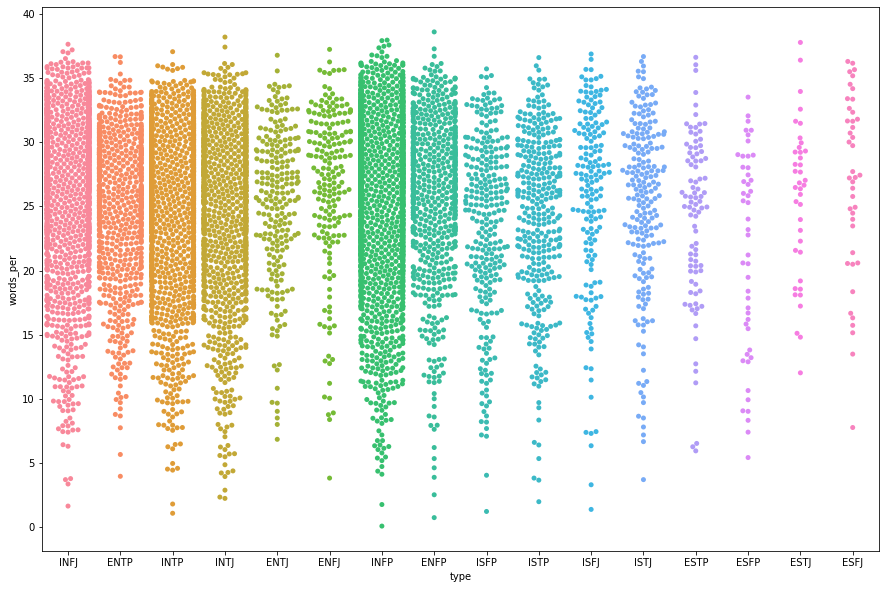

In [11]:
# words_per에 대한 시각화

plt.figure(figsize = (15,10))
sns.swarmplot('type', 'words_per', data=df)

In [21]:
df.groupby('type').agg({'type':'count'})
# 내림차순으로 출력될 수 있도록 하는 옵션 추가해두기

type
type      
ENFJ   190
ENFP   675
ENTJ   231
ENTP   685
ESFJ    42
ESFP    48
ESTJ    39
ESTP    89
INFJ  1470
INFP  1832
INTJ  1091
INTP  1304
ISFJ   166
ISFP   271
ISTJ   205
ISTP   337

In [46]:
# 링크로 설명하고 싶어하는 그들

group = df.groupby('type').agg({'words_per':['mean'], 'hyper_per':['mean']}).reset_index()
group.sort_values(('hyper_per','mean'), ascending = False)

type  words_per hyper_per
               mean      mean
13  ISFP  23.663321  0.087970
15  ISTP  24.265875  0.080831
9   INFP  25.846725  0.074825
12  ISFJ  25.781687  0.070602
11  INTP  24.902669  0.070429
8   INFJ  26.524857  0.065537
7   ESTP  24.201124  0.064719
10  INTJ  24.829679  0.063208
14  ISTJ  25.202439  0.060780
5   ESFP  21.342083  0.055417
0   ENFJ  26.687789  0.052947
6   ESTJ  25.547692  0.052821
2   ENTJ  25.311169  0.052727
1   ENFP  26.159230  0.050074
3   ENTP  25.075474  0.047912
4   ESFJ  26.748571  0.026190

In [55]:
group

type  words_per hyper_per
               mean      mean
0   ENFJ  26.687789  0.052947
1   ENFP  26.159230  0.050074
2   ENTJ  25.311169  0.052727
3   ENTP  25.075474  0.047912
4   ESFJ  26.748571  0.026190
5   ESFP  21.342083  0.055417
6   ESTJ  25.547692  0.052821
7   ESTP  24.201124  0.064719
8   INFJ  26.524857  0.065537
9   INFP  25.846725  0.074825
10  INTJ  24.829679  0.063208
11  INTP  24.902669  0.070429
12  ISFJ  25.781687  0.070602
13  ISFP  23.663321  0.087970
14  ISTJ  25.202439  0.060780
15  ISTP  24.265875  0.080831

In [56]:
df.head(10)

type                                              posts  \
0  INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...   
1  ENTP  'I'm finding the lack of me in these posts ver...   
2  INTP  'Good one  _____   https://www.youtube.com/wat...   
3  INTJ  'Dear INTP,   I enjoyed our conversation the o...   
4  ENTJ  'You're fired.|||That's another silly misconce...   
5  INTJ  '18/37 @.@|||Science  is not perfect. No scien...   
6  INFJ  'No, I can't draw on my own nails (haha). Thos...   
7  INTJ  'I tend to build up a collection of things on ...   
8  INFJ  I'm not sure, that's a good question. The dist...   
9  INTP  'https://www.youtube.com/watch?v=w8-egj0y8Qs||...   

                                               words  words_per  \
0  ['http://www.youtube.com/watch?v=qsXHcwe3krw, ...      12.10   
1  ['I'm, finding, the, lack, of, me, in, these, ...      24.38   
2  ['Good, one, _____, https://www.youtube.com/wa...      17.70   
3  ['Dear, INTP,, I, enjoyed, our, conversation, ...      22.26   
4  ['You're, fired., That's, another, silly, misc...      20.32   
5  ['18/37, @.@, Science, is, not, perfect., No, ...      30.80   
6  ['No,, I, can't, draw, on, my, own, nails, (ha...      27.56   
7  ['I, tend, to, build, up, a, collection, of, t...      25.44   
8  [I'm, not, sure,, that's, a, good, question., ...      15.74   
9  ['https://www.youtube.com/watch?v=w8-egj0y8Qs,...      25.64   

                                          hyper_text  hyper_per  \
0  ['http://www.youtube.com/watch?v=qsXHcwe3krw, ...       0.48   
1  [http://img188.imageshack.us/img188/6422/6020d...       0.18   
2  [https://www.youtube.com/watch?v=fHiGbolFFGw, ...       0.10   
3  [https://www.youtube.com/watch?v=uelHwf8o7_U, ...       0.04   
4  [https://www.youtube.com/watch?v=Xh0vA6_8mv8, ...       0.12   
5  [http://phantomshine.blogspot.com/2012/05/writ...       0.02   
6  [https://thoughtcatalog.com/heidi-priebe/2015/...       0.04   
7      [https://www.youtube.com/watch?v=e4dT8FJ2GE0]       0.02   
8  [http://i63.photobucket.com/albums/h158/trinsg...       0.46   
9  ['https://www.youtube.com/watch?v=w8-egj0y8Qs,...       0.14   

   none_hyper_per  
0           11.62  
1           24.20  
2           17.60  
3           22.22  
4           20.20  
5           30.78  
6           27.52  
7           25.42  
8           15.28  
9           25.50

In [ ]:
# 이변량 및 일변량 그래프를 사용하여 두 변수의 플롯을 그림

def plot_jointplot(mbti_type, axs, titles) :
    df = df_2[df_2["type"] == mbti_type]
    sns.jointplot("variance_of_word_counts", "words_per", data = df, kind = "hex", ax = axs, title = titles)

i = df_2["type"].unique()
k = 0
for m in range(0, 2) :
    for n in range(0, 6) :
        df_3 = df_2[df_2['type'] == i[k]]
        sns.jointplot("variance_of_word_counts", "words_per_comment", data = df_3, kind = "hex")
        plt.title(i[k])
        k += 1

# 3. Feature Engineering 


In [80]:
data = pd.read_csv('./dataset/mbti_1.csv')

In [81]:
# 데이터 나누기
from sklearn.model_selection import train_test_split

train_data, test_data=train_test_split(data,test_size=0.2,random_state=42,stratify=data.type)
print(train_data.shape, test_data.shape)

(6940, 2) (1735, 2)


In [84]:
from tqdm import tqdm
import nltk
from nltk.stem import WordNetLemmatizer

def clear_text(data):
    data_length=[]
    lemmatizer=WordNetLemmatizer()
    cleaned_text=[]
    for sentence in tqdm(data.posts):
        sentence=sentence.lower()
        
#         removing links from text data
        sentence=re.sub('https?://[^\s<>"]+|www\.[^\s<>"]+',' ',sentence)
    
#         removing other symbols
        sentence=re.sub('[^0-9a-z]',' ',sentence)
    
        
        data_length.append(len(sentence.split()))
        cleaned_text.append(sentence)
    return cleaned_text,data_length


In [85]:
train_data.posts,train_length = clear_text(train_data)

100%|████████████████████████████████████████████████████████████████████████████| 6940/6940 [00:05<00:00, 1274.33it/s]


In [86]:
test_data.posts,test_length=clear_text(test_data)

100%|████████████████████████████████████████████████████████████████████████████| 1735/1735 [00:01<00:00, 1204.83it/s]


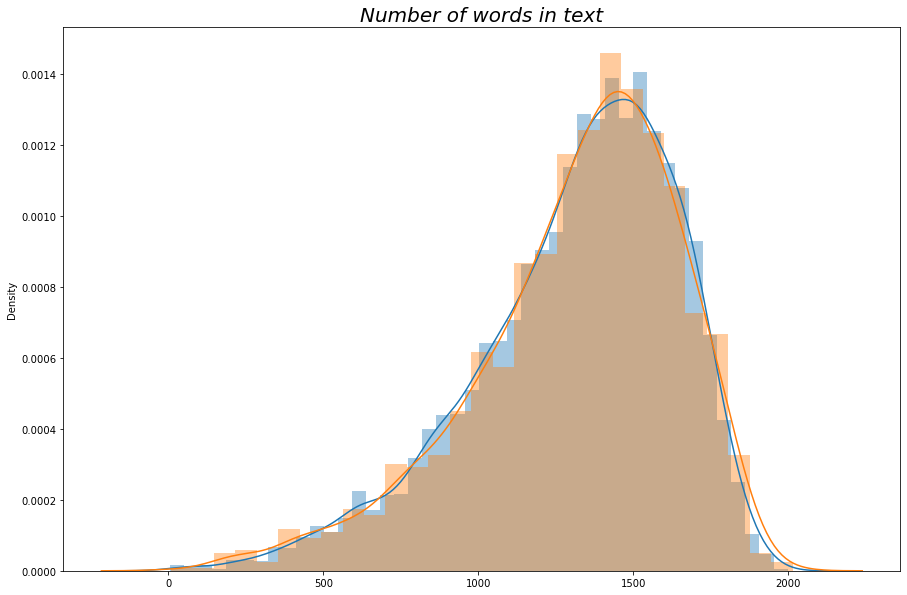

In [87]:
plt.figure(figsize=(15,10))
sns.distplot(train_length,label='train data word length')
sns.distplot(test_length,label='test data word length')
plt.title('Number of words in text',fontdict={'size':20,'style':'italic'})
plt.show()

In [90]:
! pip install plotly

You should consider upgrading via the 'C:\Users\user\anaconda3\python.exe -m pip install --upgrade pip' command.


In [91]:
import plotly.express as px
px.pie(train_data,names='type',title='Personality type',hole=0.3)

## Tokenizing words

In [99]:
class Lemmatizer(object):
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
    def __call__(self, sentence):
        return [self.lemmatizer.lemmatize(word) for word in sentence.split() if len(word)>2]

In [98]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


True

In [100]:
# TF-IDF 객체 생성
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

vectorizer = TfidfVectorizer( max_features=5000,stop_words='english',tokenizer = Lemmatizer())
vectorizer.fit(train_data.posts)

TfidfVectorizer(max_features=5000, stop_words='english',
                tokenizer=<__main__.Lemmatizer object at 0x000002CED1242370>)

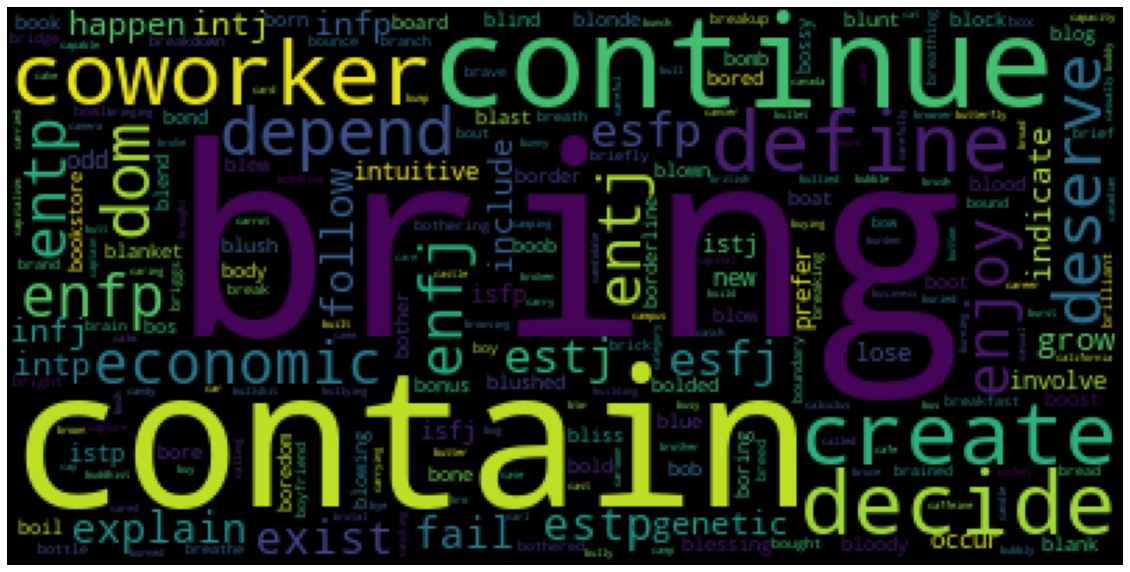

In [101]:
# word cloud 
from wordcloud import WordCloud

feature_names=vectorizer.get_feature_names()
wc=WordCloud(max_words=400)
wc.generate(' '.join(word for word in feature_names[500:3500] ))
plt.figure(figsize=(20,15))
plt.axis('off')
plt.imshow(wc)

In [102]:
train_post=vectorizer.transform(train_data.posts).toarray()
test_post=vectorizer.transform(test_data.posts).toarray()

In [103]:
train_post.shape

(6940, 5000)

In [106]:
from sklearn.preprocessing import LabelEncoder

target_encoder = LabelEncoder()
train_target = target_encoder.fit_transform(train_data.type)
test_target = target_encoder.fit_transform(test_data.type)

# 4. Modeling
여러 classification을 비교해봅니다

In [115]:
models_accuracy = {}

### Logistic Regression

In [109]:
from sklearn.linear_model import LogisticRegression

model_log=LogisticRegression(max_iter=3000,C=0.5,n_jobs=-1)
model_log.fit(train_post,train_target)

LogisticRegression(C=0.5, max_iter=3000, n_jobs=-1)

In [111]:
from sklearn.metrics import classification_report

print('train classification report \n ',classification_report(train_target,model_log.predict(train_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))

train classification report 
                precision    recall  f1-score   support

        ENFJ       0.86      0.16      0.27       152
        ENFP       0.81      0.65      0.72       540
        ENTJ       0.93      0.29      0.44       185
        ENTP       0.82      0.66      0.73       548
        ESFJ       0.00      0.00      0.00        34
        ESFP       0.00      0.00      0.00        38
        ESTJ       0.00      0.00      0.00        31
        ESTP       1.00      0.04      0.08        71
        INFJ       0.73      0.83      0.78      1176
        INFP       0.66      0.93      0.77      1465
        INTJ       0.73      0.80      0.77       873
        INTP       0.69      0.87      0.77      1043
        ISFJ       0.89      0.24      0.38       133
        ISFP       0.86      0.26      0.40       217
        ISTJ       0.86      0.27      0.41       164
        ISTP       0.86      0.52      0.65       270

    accuracy                           0.72      

In [112]:
# 이제 test 결과
print('test classification report \n',classification_report(test_target,model_log.predict(test_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))

test classification report 
               precision    recall  f1-score   support

        ENFJ       1.00      0.08      0.15        38
        ENFP       0.76      0.53      0.62       135
        ENTJ       0.75      0.13      0.22        46
        ENTP       0.66      0.51      0.58       137
        ESFJ       0.00      0.00      0.00         8
        ESFP       0.00      0.00      0.00        10
        ESTJ       0.00      0.00      0.00         8
        ESTP       0.00      0.00      0.00        18
        INFJ       0.64      0.71      0.67       294
        INFP       0.57      0.88      0.69       367
        INTJ       0.61      0.65      0.63       218
        INTP       0.66      0.83      0.74       261
        ISFJ       0.67      0.12      0.21        33
        ISFP       0.85      0.20      0.33        54
        ISTJ       0.60      0.07      0.13        41
        ISTP       0.68      0.45      0.54        67

    accuracy                           0.63      17

In [116]:
from sklearn.metrics import accuracy_score

models_accuracy['logistic regression']=accuracy_score(test_target,model_log.predict(test_post))

### Linear Support Vector Classifier

In [117]:
from sklearn.svm import SVC,LinearSVC

model_linear_svc=LinearSVC(C=0.1)
model_linear_svc.fit(train_post,train_target)

LinearSVC(C=0.1)

In [118]:
print('train classification report \n ',classification_report(train_target,model_linear_svc.predict(train_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))
print('test classification report \n',classification_report(test_target,model_linear_svc.predict(test_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))

train classification report 
                precision    recall  f1-score   support

        ENFJ       0.89      0.45      0.60       152
        ENFP       0.85      0.76      0.80       540
        ENTJ       0.92      0.65      0.76       185
        ENTP       0.84      0.82      0.83       548
        ESFJ       0.83      0.29      0.43        34
        ESFP       1.00      0.11      0.19        38
        ESTJ       1.00      0.26      0.41        31
        ESTP       0.92      0.49      0.64        71
        INFJ       0.82      0.86      0.84      1176
        INFP       0.77      0.93      0.84      1465
        INTJ       0.83      0.85      0.84       873
        INTP       0.81      0.89      0.85      1043
        ISFJ       0.91      0.67      0.77       133
        ISFP       0.89      0.57      0.70       217
        ISTJ       0.87      0.66      0.75       164
        ISTP       0.89      0.83      0.86       270

    accuracy                           0.82      

In [119]:
models_accuracy['Linear Support Vector classifier']=accuracy_score(test_target,model_linear_svc.predict(test_post))

### Support Vector classifier

In [120]:
model_svc=SVC()
model_svc.fit(train_post,train_target)
# 꽤 시간이 걸리네

SVC()

In [121]:
print('train classification report \n ',classification_report(train_target,model_svc.predict(train_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))
print('test classification report \n ',classification_report(test_target,model_svc.predict(test_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))

# 와 train accuracy 개높은데 0.95
# test는 전나 낮네 ;; 0.65

train classification report 
                precision    recall  f1-score   support

        ENFJ       0.97      0.84      0.90       152
        ENFP       0.96      0.95      0.95       540
        ENTJ       0.99      0.90      0.94       185
        ENTP       0.95      0.96      0.95       548
        ESFJ       1.00      0.56      0.72        34
        ESFP       1.00      0.37      0.54        38
        ESTJ       1.00      0.52      0.68        31
        ESTP       1.00      0.82      0.90        71
        INFJ       0.95      0.97      0.96      1176
        INFP       0.92      0.98      0.95      1465
        INTJ       0.96      0.96      0.96       873
        INTP       0.94      0.97      0.96      1043
        ISFJ       1.00      0.89      0.94       133
        ISFP       0.97      0.90      0.94       217
        ISTJ       0.94      0.92      0.93       164
        ISTP       0.97      0.94      0.95       270

    accuracy                           0.95      

In [122]:
models_accuracy['Support Vector classifier']=accuracy_score(test_target,model_svc.predict(test_post))

### Multinomial Naive Bayes

In [123]:
from sklearn.naive_bayes import MultinomialNB

model_multinomial_nb=MultinomialNB()
model_multinomial_nb.fit(train_post,train_target)

MultinomialNB()

In [124]:
print('train classification report \n ',classification_report(train_target,model_multinomial_nb.predict(train_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))
print('test classification report \n ',classification_report(test_target,model_multinomial_nb.predict(test_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))

train classification report 
                precision    recall  f1-score   support

        ENFJ       0.00      0.00      0.00       152
        ENFP       0.90      0.02      0.03       540
        ENTJ       0.00      0.00      0.00       185
        ENTP       0.91      0.06      0.11       548
        ESFJ       0.00      0.00      0.00        34
        ESFP       0.00      0.00      0.00        38
        ESTJ       0.00      0.00      0.00        31
        ESTP       0.00      0.00      0.00        71
        INFJ       0.52      0.62      0.56      1176
        INFP       0.35      0.94      0.52      1465
        INTJ       0.78      0.42      0.54       873
        INTP       0.58      0.64      0.61      1043
        ISFJ       0.00      0.00      0.00       133
        ISFP       0.00      0.00      0.00       217
        ISTJ       0.00      0.00      0.00       164
        ISTP       1.00      0.00      0.01       270

    accuracy                           0.46      

In [125]:
models_accuracy['Multinomial Naive Bayes']=accuracy_score(test_target,model_multinomial_nb.predict(test_post))

### Decision Tree Classifier

In [126]:
from sklearn.tree import DecisionTreeClassifier

model_tree=DecisionTreeClassifier(max_depth=14)
model_tree.fit(train_post,train_target)

DecisionTreeClassifier(max_depth=14)

In [127]:
print('train classification report \n ',classification_report(train_target,model_tree.predict(train_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))
print('test classification report \n ',classification_report(test_target,model_tree.predict(test_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))

train classification report 
                precision    recall  f1-score   support

        ENFJ       0.77      0.59      0.67       152
        ENFP       0.87      0.79      0.83       540
        ENTJ       0.88      0.66      0.76       185
        ENTP       0.95      0.76      0.84       548
        ESFJ       1.00      0.38      0.55        34
        ESFP       0.83      0.26      0.40        38
        ESTJ       0.86      0.39      0.53        31
        ESTP       0.86      0.45      0.59        71
        INFJ       0.81      0.85      0.83      1176
        INFP       0.62      0.94      0.75      1465
        INTJ       0.86      0.79      0.83       873
        INTP       0.89      0.81      0.85      1043
        ISFJ       0.98      0.47      0.63       133
        ISFP       0.98      0.61      0.75       217
        ISTJ       0.91      0.52      0.67       164
        ISTP       0.99      0.71      0.83       270

    accuracy                           0.79      

In [128]:
models_accuracy['Decision Tree classifier']=accuracy_score(test_target,model_tree.predict(test_post))

### Random Forest Classifier

In [129]:
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier

model_forest=RandomForestClassifier(max_depth=10)
model_forest.fit(train_post,train_target)

RandomForestClassifier(max_depth=10)

In [130]:
print('train classification report \n ',classification_report(train_target,model_forest.predict(train_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))
print('test classification report \n ',classification_report(test_target,model_forest.predict(test_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))

train classification report 
                precision    recall  f1-score   support

        ENFJ       1.00      0.01      0.03       152
        ENFP       0.99      0.47      0.64       540
        ENTJ       1.00      0.12      0.21       185
        ENTP       0.98      0.56      0.72       548
        ESFJ       1.00      0.03      0.06        34
        ESFP       0.00      0.00      0.00        38
        ESTJ       1.00      0.03      0.06        31
        ESTP       1.00      0.01      0.03        71
        INFJ       0.82      0.83      0.82      1176
        INFP       0.45      0.99      0.62      1465
        INTJ       0.93      0.73      0.82       873
        INTP       0.80      0.85      0.82      1043
        ISFJ       1.00      0.01      0.01       133
        ISFP       1.00      0.09      0.16       217
        ISTJ       1.00      0.02      0.04       164
        ISTP       1.00      0.23      0.38       270

    accuracy                           0.67      

In [131]:
models_accuracy['Random Forest Classifier']=accuracy_score(test_target,model_forest.predict(test_post))

In [ ]:

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from imblearn.over_sampling import SMOTE

### XGBoost Classifier

In [132]:
from xgboost import XGBClassifier

model_xgb = XGBClassifier(gpu_id=0,tree_method='gpu_hist',max_depth=5,n_estimators=50,learning_rate=0.1)
model_xgb.fit(train_post,train_target)

[12:20:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:223: No visible GPU is found, setting `gpu_id` to -1


XGBoostError: [12:20:53] C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/gbm/gbtree.cc:588: Check failed: common::AllVisibleGPUs() >= 1 (0 vs. 1) : No visible GPU is found for XGBoost.

In [ ]:
print('train classification report \n ',classification_report(train_target,model_xgb.predict(train_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))
print('test classification report \n ',classification_report(test_target,model_xgb.predict(test_post),target_names=target_encoder.inverse_transform([i for i in range(16)])))

In [ ]:
models_accuracy['XGBoost Classifier']=accuracy_score(test_target,model_xgb.predict(test_post))

### CatBoost Classifier

In [134]:
! pip install catboost

You should consider upgrading via the 'C:\Users\user\anaconda3\python.exe -m pip install --upgrade pip' command.


In [135]:
from catboost import CatBoostClassifier

model_cat=CatBoostClassifier(loss_function='MultiClass',eval_metric='MultiClass',task_type='GPU',verbose=False)
model_cat.fit(train_post,train_target)

CatBoostError: C:/Program Files (x86)/Go Agent/pipelines/BuildMaster/catboost.git/catboost/cuda/cuda_lib/cuda_base.h:281: CUDA error 35: CUDA driver version is insufficient for CUDA runtime version

In [ ]:
models_accuracy['CatBoost Classifier']=accuracy_score(test_target,model_cat.predict(test_post))

### 성능 비교

In [136]:
models_accuracy

{'logistic regression': 0.6282420749279539,
 'Linear Support Vector classifier': 0.661671469740634,
 'Support Vector classifier': 0.6489913544668587,
 'Multinomial Naive Bayes': 0.37809798270893374,
 'Decision Tree classifier': 0.5072046109510087,
 'Random Forest Classifier': 0.4697406340057637}

In [137]:
models_accuracy.keys()

dict_keys(['logistic regression', 'Linear Support Vector classifier', 'Support Vector classifier', 'Multinomial Naive Bayes', 'Decision Tree classifier', 'Random Forest Classifier'])

In [138]:
accuarcy=pd.DataFrame(models_accuracy.items(),columns=['Models','Test accuracy'])

In [139]:
accuarcy.sort_values(by='Test accuracy',ascending=False,ignore_index=True).style.background_gradient(cmap='Blues')